In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/movie-recommendation-system/movies.csv
/kaggle/input/movie-recommendation-system/ratings.csv


In [3]:
#import libraries
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt


In [4]:
#load data
movies_df = pd.read_csv("/kaggle/input/movie-recommendation-system/movies.csv")
ratings_df = pd.read_csv("/kaggle/input/movie-recommendation-system/ratings.csv")

movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [6]:
#creating a new dataframe with movieid as index and userid as column
top_movies = ratings_df['movieId'].value_counts().head(5000).index
filtered_df = ratings_df[ratings_df['movieId'].isin(top_movies)]

# Perform the pivot operation on the filtered dataset
pivot_df = filtered_df.pivot(index='movieId', columns='userId', values='rating')
pivot_df.head()

userId,1,2,3,4,5,6,7,8,9,10,...,162532,162533,162534,162535,162536,162537,162538,162539,162540,162541
movieId,,,,,,,,,,,,,,,,,,,,,
1,NaN,3.5,4.0,3.0,4.0,NaN,NaN,4.0,NaN,3.5,...,NaN,4.5,4.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
#Replacinf the NAN values with 0
pivot_df.fillna(0,inplace=True)
pivot_df.head()

userId,1,2,3,4,5,6,7,8,9,10,...,162532,162533,162534,162535,162536,162537,162538,162539,162540,162541
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,3.5,4.0,3.0,4.0,0.0,0.0,4.0,0.0,3.5,...,0.0,4.5,4.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**#Reducing Noise**

In [8]:
no_user_voted = ratings_df.groupby('movieId')['rating'].agg('count')
no_movies_voted = ratings_df.groupby('userId')['rating'].agg('count')

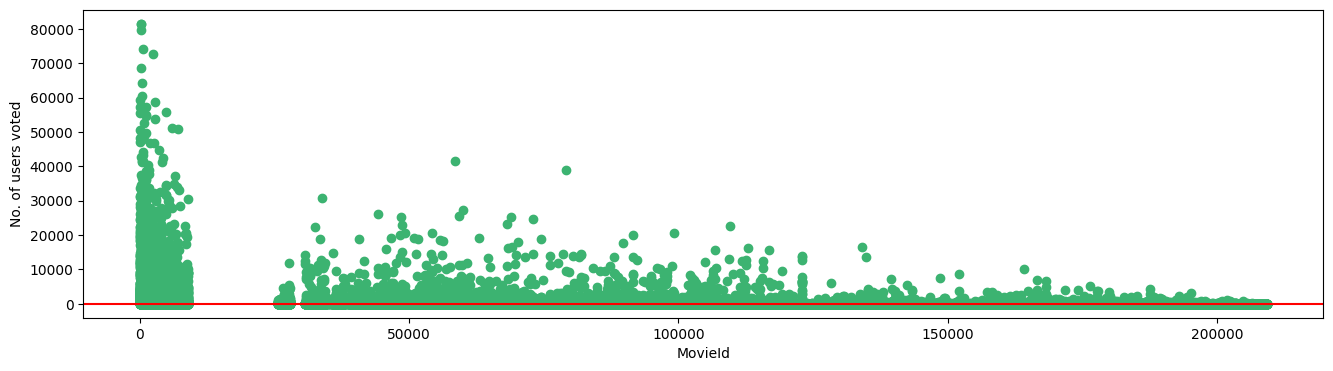

In [9]:
f,ax = plt.subplots(1,1,figsize=(16,4))
# ratings['rating'].plot(kind='hist')
plt.scatter(no_user_voted.index,no_user_voted,color='mediumseagreen')
plt.axhline(y=10,color='r')
plt.xlabel('MovieId')
plt.ylabel('No. of users voted')
plt.show()

In [14]:
#pivot_df = pivot_df.loc[no_user_voted[no_user_voted > 10].index,:]
valid_users = no_user_voted[no_user_voted > 10].index
common_users = valid_users.intersection(pivot_df.index)

# Select only the common users
pivot_df = pivot_df.loc[common_users, :]

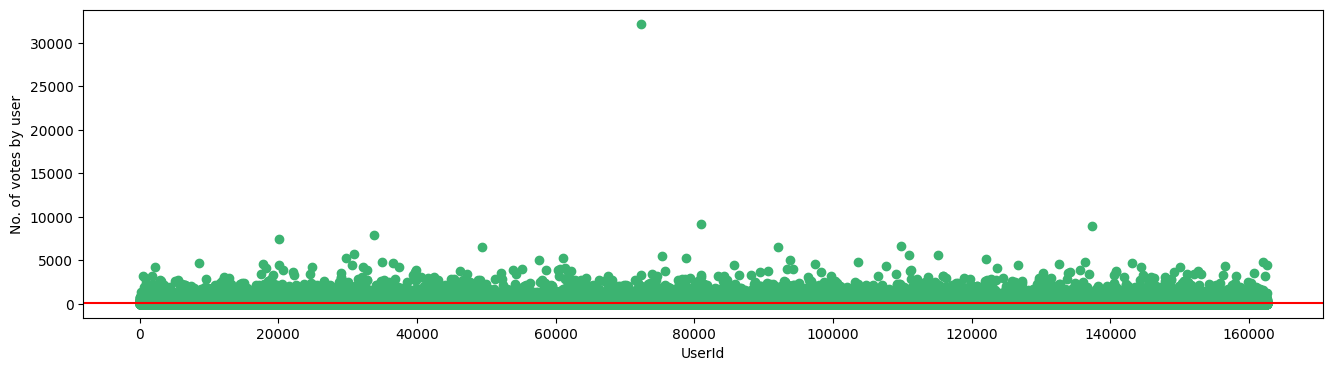

In [15]:
f,ax = plt.subplots(1,1,figsize=(16,4))
plt.scatter(no_movies_voted.index,no_movies_voted,color='mediumseagreen')
plt.axhline(y=50,color='r')
plt.xlabel('UserId')
plt.ylabel('No. of votes by user')
plt.show()

In [16]:
pivot_df=pivot_df.loc[:,no_movies_voted[no_movies_voted > 50].index]
pivot_df

userId,1,2,3,4,5,8,9,10,12,13,...,162530,162532,162533,162534,162535,162536,162537,162538,162540,162541
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,3.5,4.0,3.0,4.0,4.0,0.0,3.5,4.0,4.0,...,5.0,0.0,4.5,4.0,0.0,0.0,0.0,2.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,2.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197711,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
200818,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
201773,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Adressing Sparcity Issues

In [18]:
#using csr_matrix from scipy to eliminate sparcity
csr_data = csr_matrix(pivot_df.values)
pivot_df.reset_index(inplace=True)

In [19]:
#building the model KNN
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
knn.fit(csr_data)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

**#Recommendations**

In [26]:
def get_movie_recommendation(movie_name):
    n_movies_to_reccomend = 10
    movie_list = movies_df[movies_df['title'].str.contains(movie_name)]  
    if len(movie_list):        
        movie_idx= movie_list.iloc[0]['movieId']
        movie_idx = pivot_df[pivot_df['movieId'] == movie_idx].index[0]
        distances , indices = knn.kneighbors(csr_data[movie_idx],n_neighbors=n_movies_to_reccomend+1)    
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),key=lambda x: x[1])[:0:-1]
        recommend_frame = []
        for val in rec_movie_indices:
            movie_idx = pivot_df.iloc[val[0]]['movieId']
            idx = movies_df[movies_df['movieId'] == movie_idx].index
            recommend_frame.append({'Title':movies_df.iloc[idx]['title'].values[0],'Distance':val[1]})
        df = pd.DataFrame(recommend_frame,index=range(1,n_movies_to_reccomend+1))
        print('Top 10 Recommendations')
        return df
    else:
        return "No movies found. Please check your input"

In [27]:
get_movie_recommendation('Iron Man')

Top 10 Recommendations


,Title,Distance
1,"Dark Knight Rises, The (2012)",0.419357
2,Sherlock Holmes (2009),0.417910
3,Inception (2010),0.384049
4,WALL·E (2008),0.380230
5,Avatar (2009),0.376578
6,Star Trek (2009),0.375969
7,Batman Begins (2005),0.363623
8,Iron Man 2 (2010),0.363000
9,"Avengers, The (2012)",0.344240
10,"Dark Knight, The (2008)",0.300066
